In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchtuples as tt
import warnings

from load import read_csv

from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

from dataset import Dataset
from fedcox import Federation
from net import MLP, MLPPH, CoxPH
from discretiser import Discretiser
from interpolate import surv_const_pdf, surv_const_pdf_df

from sklearn.model_selection import KFold
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from tabulate import tabulate

from torch.utils.data import DataLoader



In [2]:
rng = np.random.default_rng(123)
_ = torch.manual_seed(123)


In [3]:
def count_benign_malignant(df):
    m_brain = df['SITE_C71'] == 1
    m_other = (df['SITE_C70'] == 1) | (df['SITE_C72'] == 1)
    benign = (df['SITE_D32'] == 1) | (df['SITE_D33'] == 1) | (df['SITE_D35'] == 1)

    print('malignant brain: ',m_brain.sum())
    print('malignant other: ',m_other.sum())
    print('benign: ',benign.sum())

    overlap = (m_brain & m_other & benign).sum()
    print(overlap)


In [4]:
datapath = './Data/data.csv'
data = read_csv(datapath)
print(data.shape)
data = data.drop(columns='PATIENTID')
print(data.columns)

(40018, 42)
Index(['GRADE', 'AGE', 'SEX', 'QUINTILE_2015', 'TUMOUR_COUNT', 'SACT',
       'REGIMEN_COUNT', 'CLINICAL_TRIAL_INDICATOR',
       'CHEMO_RADIATION_INDICATOR', 'NORMALISED_HEIGHT', 'NORMALISED_WEIGHT',
       'DAYS_TO_FIRST_SURGERY', 'DAYS_SINCE_DIAGNOSIS', 'SITE_C70', 'SITE_C71',
       'SITE_C72', 'SITE_D32', 'SITE_D33', 'SITE_D35', 'BENIGN_BEHAVIOUR',
       'CREG_L0201', 'CREG_L0301', 'CREG_L0401', 'CREG_L0801', 'CREG_L0901',
       'CREG_L1001', 'CREG_L1201', 'CREG_L1701', 'LAT_9', 'LAT_B', 'LAT_L',
       'LAT_M', 'LAT_R', 'ETH_A', 'ETH_B', 'ETH_C', 'ETH_M', 'ETH_O', 'ETH_U',
       'ETH_W', 'EVENT'],
      dtype='object')


In [5]:
# standardisation of features
cols_standardise = ['GRADE', 'AGE', 'QUINTILE_2015', 'NORMALISED_HEIGHT', 'NORMALISED_WEIGHT']
cols_minmax = ['SEX', 'TUMOUR_COUNT', 'REGIMEN_COUNT']
cols_leave = ['SACT', 'CLINICAL_TRIAL_INDICATOR', 'CHEMO_RADIATION_INDICATOR','BENIGN_BEHAVIOUR','SITE_C70', 'SITE_C71', 'SITE_C72', 'SITE_D32','SITE_D33','SITE_D35','CREG_L0201','CREG_L0301','CREG_L0401','CREG_L0801','CREG_L0901','CREG_L1001','CREG_L1201','CREG_L1701','LAT_9','LAT_B','LAT_L','LAT_M','LAT_R','ETH_A','ETH_B','ETH_C','ETH_M','ETH_O','ETH_U','ETH_W','DAYS_TO_FIRST_SURGERY']

all_cols = cols_standardise + cols_minmax + cols_leave

print(len(data.columns) == len(cols_standardise + cols_minmax + cols_leave) + 2)

standardise = [([col], StandardScaler()) for col in cols_standardise]
minmax = [([col], MinMaxScaler()) for col in cols_minmax]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardise + minmax + leave)

# discretisation
num_durations = 50
discretiser = Discretiser(num_durations, scheme='km')


True


In [6]:
def train_val_split(df, t_index, v_index, x_mapper, fit_transform=True):
    df_t = df.loc[t_index]
    df_v = df.loc[v_index]

    if fit_transform:
        x_t = x_mapper.fit_transform(df_t).astype('float32')
    else:
        x_t = x_mapper.transform(df_t).astype('float32')
    x_v = x_mapper.transform(df_v).astype('float32')

    y_t = (df_t.DAYS_SINCE_DIAGNOSIS.values, df_t.EVENT.values)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if fit_transform:
            y_t = discretiser.fit_transform(*y_t)
        else:
            y_t = discretiser.transform(*y_t)

    y_v = (df_v.DAYS_SINCE_DIAGNOSIS.values, df_v.EVENT.values)

    return x_t, y_t, x_v, y_v

In [7]:
case1 = {'num_centers' : 1, 
            'local_epochs' : [1],
            'stratify_labels' : False,
            'case_id' : 'central'}

case2 = {'num_centers' : 4, 
            'local_epochs' : [1,5,20,100],
            'stratify_labels' : False,
            'case_id' : 'iid'}

case3 = {'num_centers' : 4, 
            'local_epochs' : [1,5,20,100],
            'stratify_labels' : True,
            'case_id' : 'noniid'}

### just for val losses
if True:
    case2 = {'num_centers' : 4, 
                'local_epochs' : [1,100],
                'stratify_labels' : False,
                'case_id' : 'iid'}

    case3 = {'num_centers' : 4, 
                'local_epochs' : [1,100],
                'stratify_labels' : True,
                'case_id' : 'noniid'}
###

# cases = [case1, case2, case3]
cases = [case2, case3]
 
model_type = 'NNnph'

case_local_val_losses = []
case_global_val_losses = []

# if equal to 1 only once and only on the first fold of case 1, if equal to ev-folds times para-folds then every time in case 1
tune_tries = 5
para_round = 0

best_lr = 0.001
best_dropout = 0.1
tuning = False

reset_in = 6 

for case in cases:

    reset_in = reset_in - 1
    if reset_in == 0:
        rng = np.random.default_rng(123)
        _ = torch.manual_seed(123)  
        reset_in = 6      

    case_id = case['case_id']
    
    # federation parameters - excl lr
    num_centers = case['num_centers']
    optimizer = 'adam'
    batch_size = 256
    local_epochs = 1 # overridden below
    base_epochs = 100
    print_every = 100
    # no stratification if None and False
    stratify_col = None
    stratify_labels = case['stratify_labels']

    # this is set automatically
    stratify_on = None

    if stratify_col != None:
        stratify_on = all_cols.index(stratify_col)
        print(f'Stratify on index: {stratify_on}')
    if stratify_labels:
        stratify_on = 0
        print(f'Stratify on label index: {stratify_on}')
        
    # case level
    for local_epochs in case['local_epochs']:
        
        epochs = max(1, base_epochs // local_epochs)

        log = f'./training_log_M{model_type}C{case_id}S{stratify_on}C{num_centers}L{local_epochs}.txt'
        with open(log, 'w') as f:
            print(f'-- Centers: {num_centers}, Local rounds: {local_epochs}, Global rounds: {epochs} --', file=f)

        # CV setup
        n_splits = 5
        random_state = rng.integers(0,1000)
        scores = []
        briers = []
        parameters = []

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        cv_round = 0
        
        # CV for average performance
        for train_index, test_index in kf.split(data):
            with open(log, 'a') as f:
                print(f'-- Eval CV fold: {cv_round} --', file=f)
            cv_round += 1
            x_train, y_train, x_test, y_test = train_val_split(data, train_index, test_index, x_mapper, fit_transform=True)
            test_loader = DataLoader(Dataset(x_test, y_test), batch_size=256, shuffle=False)

            # MLP parameters - excl dropout
            dim_in = x_train.shape[1]
            num_nodes = [32, 32]
            dim_out = len(discretiser.cuts)
            batch_norm = True

            # tuning
            if tuning:
                # grid for parameter 1 to be tuned
                learning_rates = [0.1, 0.01, 0.001, 0.0001]

                # grid for parameter 2 to be tuned
                # >>> for CoxPH just set to 0 - doesn't make a difference
                dropouts = [0.1, 0.5, 0.75] 
                # dropouts = [0]
                
                # [[scores for each lr x dropout from fold 1], [..from fold2], etc.]
                tuning_scores = []    

                para_splits = 5
                para_kf = KFold(n_splits=para_splits)
                for t_index, v_index in kf.split(x_train):
                    
                    x_t, y_t, x_v, y_v = train_val_split(data.loc[train_index].reset_index(), t_index, v_index, x_mapper, fit_transform=False)

                    val_loader = DataLoader(Dataset(x_v, y_v), batch_size=256, shuffle=False)

                    # each entry corresponds to the score for a particular lr x dropout pair
                    fold_scores = []
                    for lr in learning_rates:
                        for dropout in dropouts:
                            
                            para_epochs = max(1,epochs // 5)

                            # >>> comment out the unnecessary ones 
                            net = MLP(dim_in=dim_in, num_nodes=num_nodes, dim_out=dim_out, batch_norm=batch_norm, dropout=dropout)
                            # net = CoxPH(dim_in=dim_in, dim_out=dim_out, batch_norm=batch_norm)
                            # net = MLPPH(dim_in=dim_in, num_nodes=num_nodes, dim_out=dim_out, batch_norm=batch_norm, dropout=dropout)
                            
                            fed = Federation(features=x_t, labels=y_t, net=net, num_centers=num_centers, optimizer=optimizer, lr=lr, stratify_on=stratify_on, stratify_labels=stratify_labels, batch_size=batch_size, local_epochs=local_epochs)
                            ran_for = fed.fit(epochs=para_epochs, patience=999, print_every=print_every, take_best=True, verbose=False)    
                            # ran_for = fed.fit(epochs=para_epochs, patience=999, print_every=print_every, take_best=False, verbose=False)    

                            surv = fed.predict_surv(val_loader)[0]
                            surv = surv_const_pdf_df(surv, discretiser.cuts) # interpolation

                            ev = EvalSurv(surv, *y_v, censor_surv='km')
                            score = ev.concordance_td('antolini')
                            fold_scores.append(score)
                            with open(log, 'a') as f:
                                print(f'Tuning CV fold {para_round} with {ran_for} rounds: conc = {score}, lr = {lr}, dropout = {dropout}', file=f)
                    tuning_scores.append(fold_scores)
                    
                    para_round += 1
                    if para_round >= tune_tries:
                        tuning = False
                        break # out of para loop

                tuning_scores = np.array(tuning_scores)
                avg_scores = np.mean(tuning_scores, axis=0)
                best_combo_idx = np.argmax(avg_scores)
                best_lr_idx = best_combo_idx // len(dropouts)
                best_dropout_idx = best_combo_idx % len(dropouts)
                best_lr = learning_rates[best_lr_idx]
                best_dropout = dropouts[best_dropout_idx]


            # >>> comment out the unnecessary ones
            net = MLP(dim_in=dim_in, num_nodes=num_nodes, dim_out=dim_out, batch_norm=batch_norm, dropout=best_dropout)
            # net = CoxPH(dim_in=dim_in, dim_out=dim_out, batch_norm=batch_norm)
            # net = MLPPH(dim_in=dim_in, num_nodes=num_nodes, dim_out=dim_out, batch_norm=batch_norm, dropout=best_dropout)

            fed = Federation(features=x_train, labels=y_train, net=net, num_centers=num_centers, optimizer=optimizer, lr=best_lr, stratify_on=stratify_on, stratify_labels=stratify_labels, batch_size=batch_size, local_epochs=local_epochs)
            ran_for = fed.fit(epochs=epochs, patience=999, print_every=print_every, take_best=True)    
            # ran_for = fed.fit(epochs=epochs, patience=999, print_every=print_every, take_best=False)    
            
            surv = fed.predict_surv(test_loader)[0]
            surv = surv_const_pdf_df(surv, discretiser.cuts) # interpolation
            
            time_grid = np.linspace(y_test[0].min(), y_test[0].max(), 100)
            
            ev = EvalSurv(surv, *y_test, censor_surv='km')
            score = ev.concordance_td('antolini')
            scores.append(score)

            brier = ev.integrated_brier_score(time_grid) 
            briers.append(brier)
            
            parameters.append({'lr' : best_lr, 'dropout' : best_dropout})
            case_local_val_losses.append(fed.val_losses)
            case_global_val_losses.append(fed.global_val_losses)

            with open(log, 'a') as f:
                print(f'>> After {ran_for} rounds, model from round {fed.model_from_round} - best parameters: conc = {score}, brier = {brier}, LR = {best_lr}, dropout = {best_dropout}', file=f)

        with open(log, 'a') as f:
            print(f'Avg concordance: {sum(scores) / len(scores)}, Integrated Brier: {sum(briers) / len(briers)}', file=f)


Stratify on label index: 0
 \Latest training stats after 100 global rounds:
Training loss : 2.8530534506535856
Validation loss : 2.758528013384758
Epochs exhausted, model from round 14
 \Latest training stats after 100 global rounds:
Training loss : 2.822108829319477
Validation loss : 2.714800993263963
Epochs exhausted, model from round 13
 \Latest training stats after 100 global rounds:
Training loss : 2.78843202534289
Validation loss : 2.6756004229453585
Epochs exhausted, model from round 14
 \Latest training stats after 100 global rounds:
Training loss : 2.7985561921019984
Validation loss : 2.6812770467324585
Epochs exhausted, model from round 13
 \Latest training stats after 100 global rounds:
Training loss : 2.8202127853828225
Validation loss : 2.7127167193146495
Epochs exhausted, model from round 12
Epochs exhausted, model from round 4
Epochs exhausted, model from round 4
Epochs exhausted, model from round 3
Epochs exhausted, model from round 4
Epochs exhausted, model from round 

[[18.06906463 12.123512    8.16018584  5.66621966  4.1014692   3.25370773
   2.76152205  2.52037864  2.30293756  2.2042964   2.10671998  2.04118164
   2.04999743  2.02595286  2.03114257  2.04067792  2.07628295  2.08416269
   2.11338682  2.13623836  2.16904089  2.20235354  2.22320235  2.25334844
   2.27596931  2.30652175  2.34260404  2.371698    2.39908445  2.42199674
   2.45367373  2.48146717  2.49799522  2.52264004  2.53266607  2.55099357
   2.56452611  2.57407783  2.58215536  2.59043816  2.5899068   2.59420655
   2.60287013  2.60771055  2.61263184  2.61209355  2.61519387  2.61669183
   2.62670389  2.62840625  2.63000908  2.63210671  2.63265386  2.63759431
   2.6397345   2.64401591  2.64894849  2.65476818  2.65469993  2.6586508
   2.66078886  2.65518193  2.65503165  2.66450029  2.667665    2.66981817
   2.67315094  2.67658297  2.68138799  2.68275664  2.68423846  2.68852977
   2.6911488   2.69471083  2.69015331  2.70165722  2.70165544  2.70355821
   2.70826014  2.70658683  2.71837267  

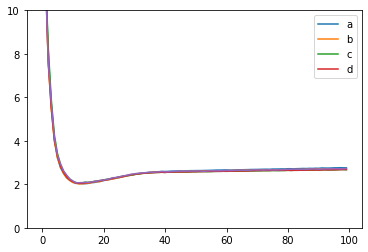

In [51]:
for i, case in enumerate(cases):
    for local_epochs in case['local_epochs']:
        losses = np.array(case_local_val_losses[5*i:5*(i+1)])
        case_id = case['case_id']
        lossfile = f'./local_loss_M{model_type}C{case_id}L{local_epochs}.npy'
        np.save(lossfile, losses)

        losses = np.array(case_global_val_losses[5*i:5*(i+1)])
        lossfile = f'./global_loss_M{model_type}C{case_id}L{local_epochs}.npy'
        np.save(lossfile, losses)


losses = np.array(case_global_val_losses[0:5])
print(losses)

plt.plot(losses[0].T)
plt.plot(losses[1].T)
plt.plot(losses[2].T)
plt.plot(losses[3].T)
plt.plot(losses[4].T)

x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,0,10))
plt.legend(['a','b','c','d'])

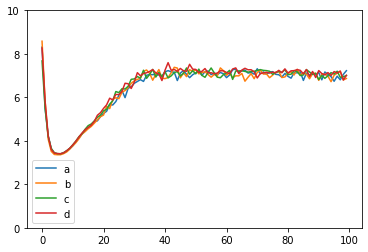

In [43]:
test = np.load('loss_MCoxphCnoniidL100.npy')
plt.plot(test[0][0].T)
plt.plot(test[1][0].T)
plt.plot(test[2][0].T)
plt.plot(test[3][0].T)
x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,0,10))
plt.legend(['a','b','c','d'])
